# Problem definition

SEC filings are long, filled with boilerplate language, and often difficult to parse through even as an experienced analyst. Let's assume that I have the following question:

> "What was the annual revenue for TSLA in 2024, and what was media sentiment after the SEC 10-K filings were released?"

For the sake of simplicity, let's assume the answer can be obtained with the following two sources:
- [TSLA 2024 10-K SEC filing](https://www.sec.gov/Archives/edgar/data/1318605/000162828025003063/tsla-20241231.htm#ie9fbbc0a99a6483f9fc1594c1ef72807_157), 347,000 tokens
- [Yahoo Finance article](https://finance.yahoo.com/news/tesla-inc-tsla-q4-2024-072241602.html), 5,000 tokens

To implement an architecture that could answer these questions, we have the following options. There are lots of LLM's we could use, but let's assume that we're using GPT 4o at commercial API usage rates. 

- GPT-4o with unfiltered context: Manually upload full context to GPT API. 
- GPT-4o with web search: Ask the question directly, and don't provide context.
- GPT-4o with keyword search: BM25 search to fetch top-N chunks that match query terms to article metadata, and send those chunks to the API.
- RAG with semantic search (GPT-4o): Search vector database for context, and  upload to GPT-4o

Using our article baseline, and assuming that each method can accurately answer the question, here are the daily cost extrapolations for a platform with the following levels of activity:

- We have a platform with 1000 concurrent users at any given moment
- These users use the platform for 10 hours per day
- Each user asks 1 question every 3 minutes, each similar to the above question (39 tokens).

| Scenario                           | Input Tokens | Output Tokens | Cost per Query (USD) | Total Daily Cost (USD) |
|------------------------------------|--------------|----------------|-----------------------|-------------------------|
| GPT-4o with unfiltered context     | 347,000      | 200            | $1.7390               | $347,800.00             |
| GPT-4o with web search             | 7,500        | 200            | $0.0415               | $8,300.00               |
| Keyword search + GPT-4o            | 3,000        | 200            | $0.0190               | $3,800.00               |
| RAG with semantic search (GPT-4o)  | 2,000        | 200            | $0.0140               | $2,800.00               |
| RAG with semantic search (GPT 3.5) | 2,000        | 200            | $0.0013               | $260              |

Our API costs would be 66% cheaper using a RAG compared to web search. If we optimize the semantic retrieval methodology for accuracy and use GPT 3.5 instead of 4o, it would be 97% cheaper. 

| Scenario                           | High Accuracy | Cost Efficient | Low Latency | Scalable | Curated Sources |
|------------------------------------|----------------|----------------|-------------|----------|---------------------|
| GPT-4o with unfiltered context     | ✅             | ❌             | ❌          | ❌       | ✅                  |
| GPT-4o with web search             | ✅             | ✅             | ✅          | ✅       | ❌                  |
| Keyword search + GPT-4o            | ❌             | ✅             | ✅          | ✅       | ✅                  |
| RAG with semantic search (GPT-4o)  | ✅             | ✅             | ✅          | ✅       | ✅                  |
| RAG with semantic search (GPT-3.5) | ✅             | ✅             | ✅          | ✅       | ✅                  |

# Evaluation Criteria

We'll implement all four scenarios above, and evaluate them on the following criteria:

- Tier 1: Single-source QA accuracy. *How well does our engine answer questions about the 10-K filings?*
    - Evaluation data set: [financial-qa-10k](https://huggingface.co/datasets/virattt/financial-qa-10K)
    - Evaluation metrics:
        - ROUGE
        - Recall@k for chunk retrieval
<!-- - Tier 2 (if time permits): Multi-source QA accuracy. *How well does our engine answer questions about the 10-K filings AND related media?*
    
    - Evaluation metrics:
        -  -->

# Datasets to use:

<!-- - **SEC 10-k filings** for the years 2020-2023 for AAPL, NVDA, TSLA, GOOGL. We'll scrape this data with the [EDGAR-CRAWLER](https://github.com/lefterisloukas/edgar-crawler) project. -->
- **Source SEC Filings**: the [financial-reports-sec](https://huggingface.co/datasets/JanosAudran/financial-reports-sec) dataset is already cleaned and separated into sections. I'll use this for simplicity; a real-life scenario would include implementing a pipeline to generate the features. 
- **Evaluation set**: QA answer responses based on the [financial-qa-10k](https://huggingface.co/datasets/virattt/financial-qa-10K) labeled dataset from HuggingFace. 


# How to implement

1. Download both the SEC docs and the evaluation set
2. 

# EDA

## SEC 10-K Filings

First we'll get the structured 10K filings

In [1]:
#imports 
%load_ext autoreload
%autoreload 2
import sys, os
from pathlib import Path

# Add project root to sys.path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

sys.path.append("..")
import numpy as np
import pandas as pd
from pprint import pprint


In [2]:
from src.download_data import load_filings

tickers_of_interest = ["AAPL", "TSLA", "META", "NVDA", "CVX"]

df_filings = load_filings(tickers=tickers_of_interest, refresh=False)

/Users/jon/GitHub/dowjones-takehome/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 64 filings from ../data/df_filings.csv


In [12]:
import ast

#display the tenth row in df_filings
display(df_filings.iloc[10])
example = ast.literal_eval(df_filings['report'][10])

example['section_8']

split                                                      train
cik                                                      1318605
ticker                                                      TSLA
fiscal_year                                                 2019
doc_id                                                       NaN
report         {'section_1': ['ITEM 1. BUSINESS Overview We d...
returns        {'1d': {'closePriceEndDate': 53.3353347778, 'c...
Name: 10, dtype: object

['ITEM 8.',
 'FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA Index to Consolidated Financial Statements Page Report of Independent Registered Public Accounting Firm Consolidated Balance Sheets Consolidated Statements of Operations Consolidated Statements of Comprehensive Loss Consolidated Statements of Redeemable Noncontrolling Interests and Equity Consolidated Statements of Cash Flows Notes to Consolidated Financial Statements Report of Independent Registered Public Accounting Firm To the Board of Directors and Stockholders of Tesla, Inc.',
 'Opinions on the Financial Statements and Internal Control over Financial Reporting We have audited the accompanying consolidated balance sheets of Tesla, Inc. and its subsidiaries (the “Company”) as of December 31, 2019 and 2018, and the related consolidated statements of operations, of comprehensive loss, of redeemable noncontrolling interests and equity and of cash flows for each of the three years in the period ended December 31, 2019, including 

Let's see if we have a similar number of sources. 

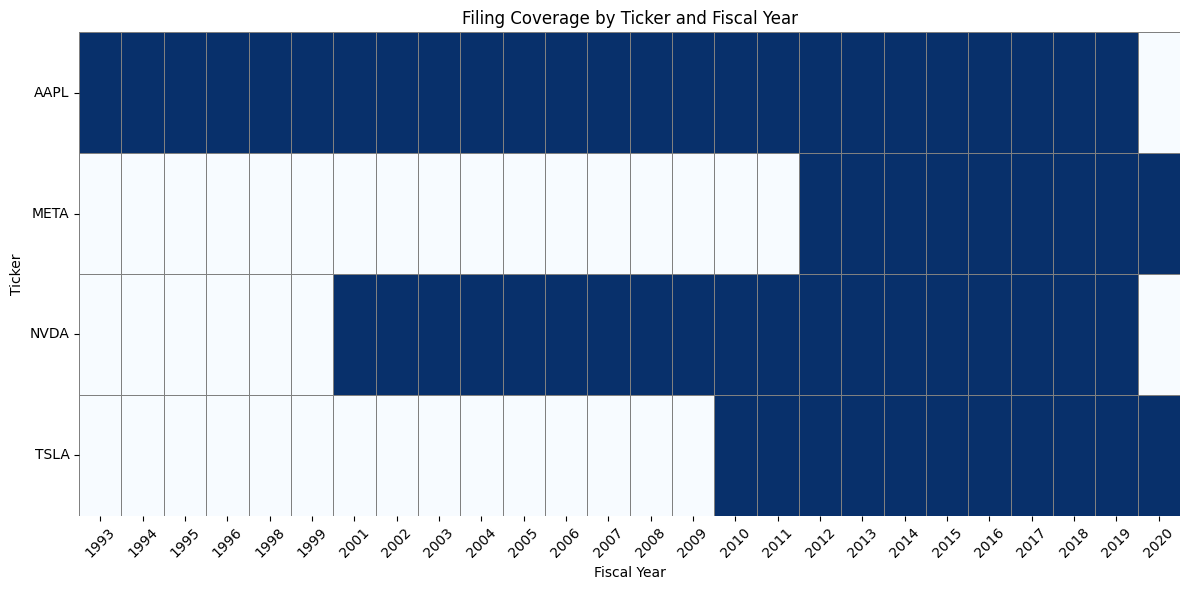

: 

: 

In [ ]:
from eda.viz import plot_filing_coverage

plot_filing_coverage(df_filings)

We have full coverage from 2012-2019. We'll limit the df to only cover these years. 

In [17]:
df_filings = df_filings[df_filings['fiscal_year'].between(2012, 2019)]

: 

: 

In [22]:
df_filings.head()

,split,cik,ticker,fiscal_year,doc_id,report,returns
1,train,1326801,META,2019,NaN,{'section_1': ['Item 1.Business Overview Our m...,"{'1d': {'closePriceEndDate': 201.9100036621, '..."
2,train,1326801,META,2018,NaN,{'section_1': ['Item 1.Business Overview Our m...,"{'1d': {'closePriceEndDate': 165.7100067139, '..."
3,train,1326801,META,2017,NaN,{'section_1': ['Item 1.Business Overview Our m...,"{'1d': {'closePriceEndDate': 190.2799987793, '..."
4,train,1326801,META,2016,NaN,{'section_1': ['Item 1.Business Overview Our m...,"{'1d': {'closePriceEndDate': 132.0599975586, '..."
5,train,1326801,META,2015,NaN,{'section_1': ['Item 1.Business Overview Our m...,"{'1d': {'closePriceEndDate': 112.2099990845, '..."


: 

: 

Now let's compare the length of documents for each year. 

Let's see if there are vastly different distributions in the number of tokens per ticker per year. 

In [ ]:
from src.filing_exploder import FilingExploder
df_filings_exploded = FilingExploder().explode(df=df_filings)
pprint(df_filings['text'][0])


: 

: 

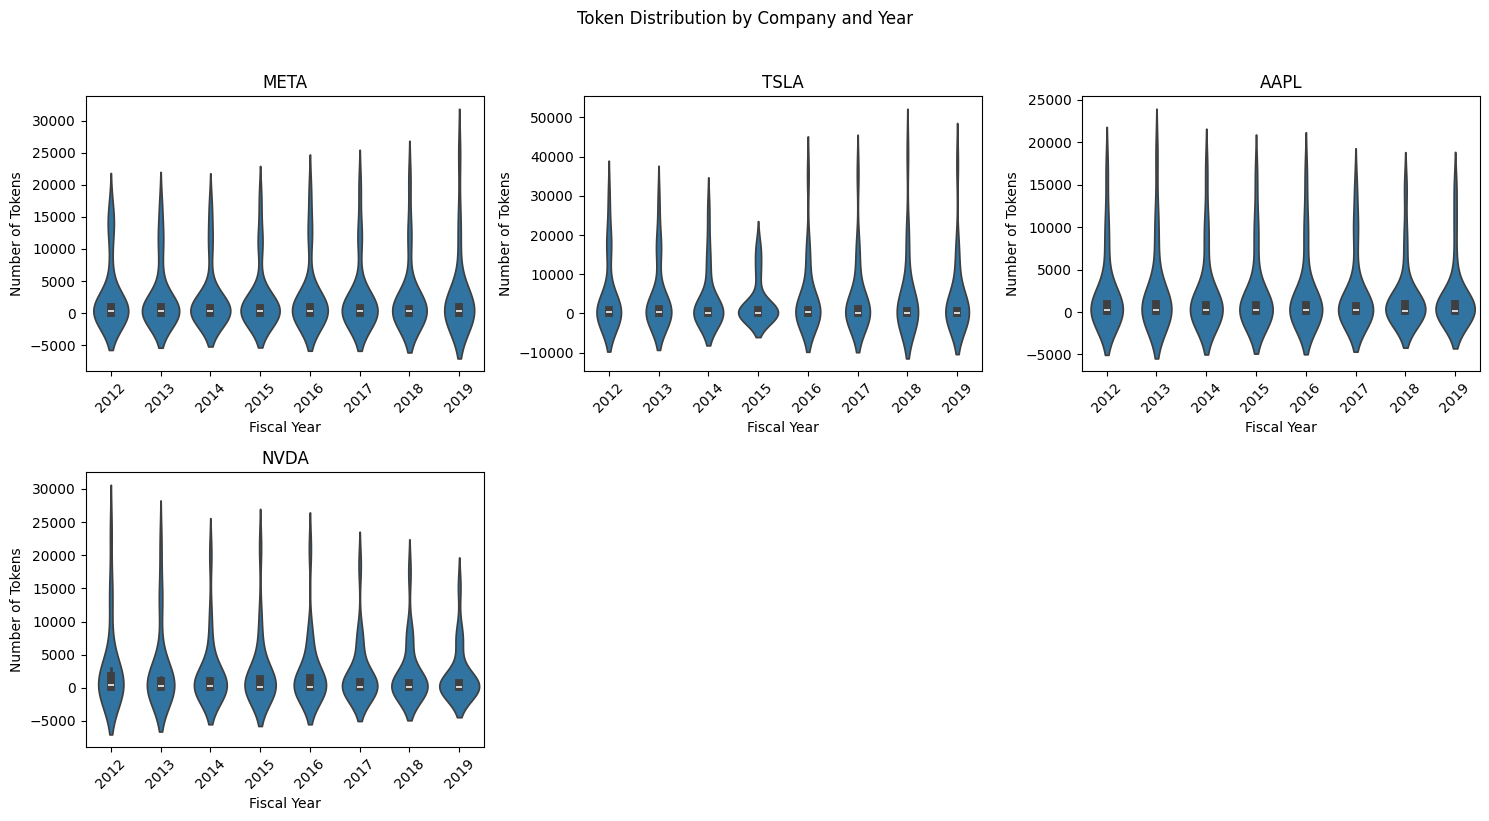

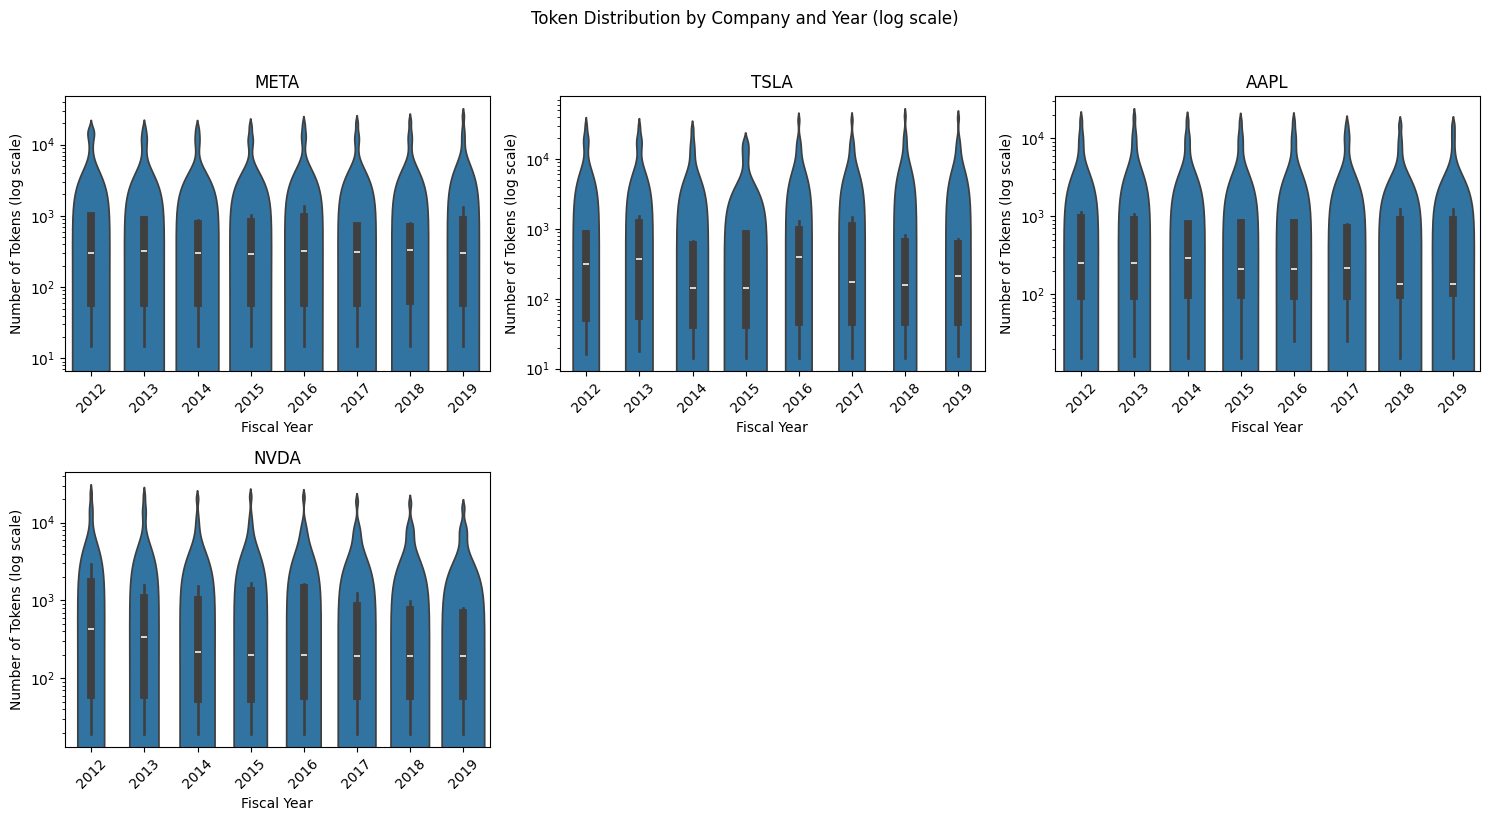

: 

: 

In [ ]:
from eda.viz import count_tokens, plot_token_distribution

df_filings_exploded['num_tokens'] = pd.to_numeric(df_filings_exploded['text'].apply(count_tokens), errors='coerce')

plot_token_distribution(df_filings_exploded)
plot_token_distribution(df_filings_exploded, log_scale=True)

In [ ]:
df_filings.head(20)

## Chunking

OK so we have some very long sentences. Most are between 0-5k tokens with a long tail up to 50k. So, we're going to have to do some pretty significant chunking. 

- Target chunk size: 350 tokens (ideally a full sentence)
- Overlap: 50 tokens
- Hard ceiling: 800


In [25]:
from src.chunkers import SmartChunker
from src.filing_exploder import FilingExploder

exploder = FilingExploder()
df_filings_exploded = exploder.explode(df=df_filings)

chunker = SmartChunker(target_tokens=350, hard_ceiling=800, overlap_tokens=50)
chunks = chunker.run(df_filings_exploded)


## Embeddings

Now for this, usually I would prefer to use a fine-tuned text embedding model that's been trained mostly on a corpus of financial texts. There are plenty of fine-tuned models, and we could even do our own fine-tuning on a multi-billion parameter Llama model, but for the purpose of this exercise I will just use OpenAI embeddings. 

In production I assume we'll use our own embedding model hosted on our own infra, so I won't calculate this cost into the final savings. 

In [28]:
from src.embedding import embed_texts
import pickle

if os.path.exists('../embeddings/chunks_embeddings.pkl'):
    with open('../embeddings/chunks_embeddings.pkl', 'rb') as f:
        ids, vectors, metas = pickle.load(f)
else:
    ids, vectors, metas = embed_texts(chunks)
    with open('../embeddings/chunks_embeddings.pkl', 'wb') as f:
        pickle.dump((ids, vectors, metas), f)

In [44]:
chunks[0]

Chunk(id='META_2019_1_0', text='Item 1 – Business Overview: Item 1.Business Overview Our mission is to give people the power to build community and bring the world closer together. We build useful and engaging products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, and in-home devices. We also help people discover and learn about what is going on in the world around them, enable people to share their opinions, ideas, photos and videos, and other activities with audiences ranging from their closest family members and friends to the public at large, and stay connected everywhere by accessing our products, including: • Facebook. Facebook enables people to connect, share, discover, and communicate with each other on mobile devices and personal computers. There are a number of different ways to engage with people on Facebook, including News Feed, Stories, Marketplace, and Watch. Instagram. Instagram bring

Now we create our vector DB. I'm choosing to use Qdrant because unlike FAISS it can handle metadata, which we have, and it's more widely used in production environments. 

In [43]:
from src.vector_db import VectorStore

# initialize
vs = VectorStore()
vs.init_collection()

# first upload: 10k SEC filings
vs.upsert(
    texts=[c.text for c in chunks],
    metas=[c.metadata for c in chunks],
    ids=list(range(len(chunks))),
)

# query
results = vs.search("What risks did Meta mention in 2019?", top_k=10)


BadRequestError: Error code: 400 - {'error': {'message': 'Requested 3141414 tokens, max 300000 tokens per request', 'type': 'max_tokens_per_request', 'param': None, 'code': 'max_tokens_per_request'}}

In [98]:
from src.download_data import load_news


df_news = load_news(tickers_of_interest)
display(df_news.head())
print(df_news.shape)

,amp_url,article_url,author,description,id,image_url,keywords,published_utc,publisher,tickers,title,content,raw_response,label_type,label_time,label_sentiment
38,https://www.benzinga.com/amp/content/34263885,https://www.benzinga.com/analyst-ratings/analy...,Shanthi Rexaline,"Tesla, Inc. (NASDAQ:TSLA) bear Gordon Johnson ...",559c0b74-0e3c-401e-996c-4894ae7eca87,https://cdn.benzinga.com/files/images/story/20...,"[News, Analyst Color, Equities, Top Stories]",2023-09-06 06:47:47,"{'name': 'Benzinga', 'homepage_url': 'https://...",[TSLA],Tesla Stock Could Be In For More Downside As '...,Tesla Stock Could Be In For More Downside As '...,"```\nNews Type: [1][c] Company-Specific News, ...","[[1][c] Company-Specific News, [2][c] Stock Re...","[[1][a] Short-Term Retrospective (≤ 3 months),...",[[3][a] Bearish]
81,https://www.zacks.com/amp/stock/news/2144194/a...,https://www.zacks.com/stock/news/2144194/alpha...,Zacks Equity Research,Alphabet (GOOGL) has received quite a bit of a...,9ef9ae45-ac14-4521-88b1-1187129fc26b,https://staticx-tuner.zacks.com/images/default...,None,2023-09-04 13:00:11,"{'name': 'Zacks Investment Research', 'homepag...",[GOOGL],Alphabet Inc. (GOOGL) is Attracting Investor A...,Alphabet Inc. (GOOGL) is Attracting Investor A...,"```\nNews Type: [1][c] Company-Specific News, ...","[[1][c] Company-Specific News, [2][c] Stock Re...","[[2][a] Real-Time Market Developments, [3][a] ...",[[1][a] Bullish]
328,https://www.globenewswire.com/news-release/202...,https://www.globenewswire.com/news-release/202...,"Rackspace Technology, Inc.",Laufende Zusammenarbeit zwischen Rackspace und...,339fee04-f947-419e-b7f0-7ea76609c193,https://ml.globenewswire.com/Resource/Download...,"[Partnerships, Product / Services Announcement]",2023-08-23 13:14:00,"{'name': 'GlobeNewswire Inc.', 'homepage_url':...",[RXT],Rackspace Technology kündigt neue Zusammenarbe...,Rackspace Technology kündigt neue Zusammenarbe...,"```\nNews Type: [1][c] Company-Specific News, ...","[[1][c] Company-Specific News, [1][a] Macro & ...",[[2][a] Real-Time Market Developments],[[1][b] Growth-Oriented]
559,https://www.globenewswire.com/news-release/202...,https://www.globenewswire.com/news-release/202...,Absci Corporation,Entered into partnership with Google Ventures-...,a8bb16fa-2ab7-4d3d-a901-cd8d61b9fdfe,https://ml.globenewswire.com/Resource/Download...,[Earnings Releases and Operating Results],2023-08-14 12:02:00,"{'name': 'GlobeNewswire Inc.', 'homepage_url':...",[ABSI],Absci Reports Business Updates and Second Quar...,Absci Reports Business Updates and Second Quar...,"```\nNews Type: [1][c] Company-Specific News, ...","[[1][c] Company-Specific News, [2][a] Fundamen...","[[1][a] Short-Term Retrospective (≤ 3 months),...",[[1][b] Growth-Oriented]
607,https://www.zacks.com/amp/stock/news/2135582/i...,https://www.zacks.com/stock/news/2135582/inves...,Zacks Equity Research,Alphabet (GOOGL) has been one of the stocks mo...,6bd48556-014d-4c21-b3af-fffda33b11ff,https://staticx-tuner.zacks.com/images/default...,None,2023-08-11 13:00:12,"{'name': 'Zacks Investment Research', 'homepag...",[GOOGL],Investors Heavily Search Alphabet Inc. (GOOGL)...,Investors Heavily Search Alphabet Inc. (GOOGL)...,"```\nNews Type: [2][a] Fundamental Analysis, [...","[[2][a] Fundamental Analysis, [2][c] Stock Rec...",[[2][b] Recent Trends (Past Few Weeks – Ongoin...,[[1][a] Bullish]


(214, 16)


# Preprocessing

## Filings

# Chunking

In [139]:
from src.filing_exploder import FilingExploder, FilingPreprocessor, Chunker

df_items = FilingExploder().explode(df_filings)

# Create two versions - one with stopwords, one without
cleaner = FilingPreprocessor(stopwords=None, spacy_model="en_core_web_sm")
# cleaner_no_stopwords = FilingPreprocessor(stopwords=fin_stopwords, spacy_model="en_core_web_sm")

df_items["clean_text_with_stopwords"] = df_items["text"].map(cleaner.clean)
# df_items["clean_text_no_stopwords"] = df_items["text"].map(cleaner_no_stopwords.clean)

chunker = Chunker()
chunks = []
# chunks_no_stopwords = []

for _, row in df_items.iterrows():
    meta = {"ticker": row["ticker"], "fiscal_year": row["fiscal_year"], "item": row["item"]}
    chunks.extend(chunker.chunk(row["clean_text_with_stopwords"], meta))
    # chunks_no_stopwords.extend(chunker.chunk(row["clean_text_no_stopwords"], meta))

In [140]:
chunks[0]

Chunk(id='META_2020_1_0', text='item business overview item 1.business overview mission people power build community bring world close build useful engaging product enable people connect share friend family mobile device personal computer virtual reality headset home device help people discover learn go world enable people share opinion idea photo video activity audience range close family member friend public large stay connected access product include facebook facebook enable people connect share discover communicate mobile device personal computer number different way engage people facebook build community include facebook news feed story group shop marketplace news watch instagram instagram bring people close people thing love place people express photo video private messaging connect shop favorite business creator instagram feed story reel IGTV live shop message messenger messenger simple powerful message application people connect friend family group business platform device chat